In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl

In [3]:
%matplotlib inline

Local level model for time series:
$$u_t \sim \mathcal{N}\left(u_{t-1}, \sigma^2_{\xi}\right)$$
$$y_t \sim \mathcal{N}\left(u_t, \sigma^2_\epsilon\right)$$
$\sigma^2_{\xi}$ is level disturbance, $\sigma^2_\epsilon$ is observation disturbance.

<br>
$$v_t \sim \mathcal{N}\left(

In [4]:
# make data
np.random.seed(59)
data = []
start_point = 10.0
data.append(start_point)
for i in range(100):
    if i == 0:
        temp=start_point
    else:
        next_temp = temp + np.random.normal(0, 1)
        data.append(next_temp)
        temp = next_temp

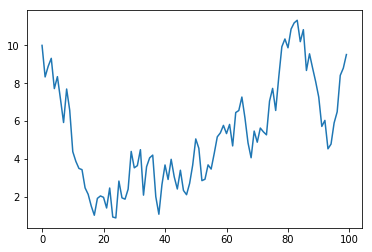

In [5]:
pl.plot(list(range(len(data))), data)

In [14]:
with pm.Model() as m_local:
    sy = pm.HalfCauchy('sy', 3)
    su = pm.HalfCauchy('su', 3)
    u_t = pm.GaussianRandomWalk('u_t', mu=0, sd=su, shape=len(data))
    y_t = pm.Normal('y_t', mu=u_t, sd=sy, observed=data)
    trace_local = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u_t, su_log__, sy_log__]
100%|██████████| 1500/1500 [00:03<00:00, 452.57it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


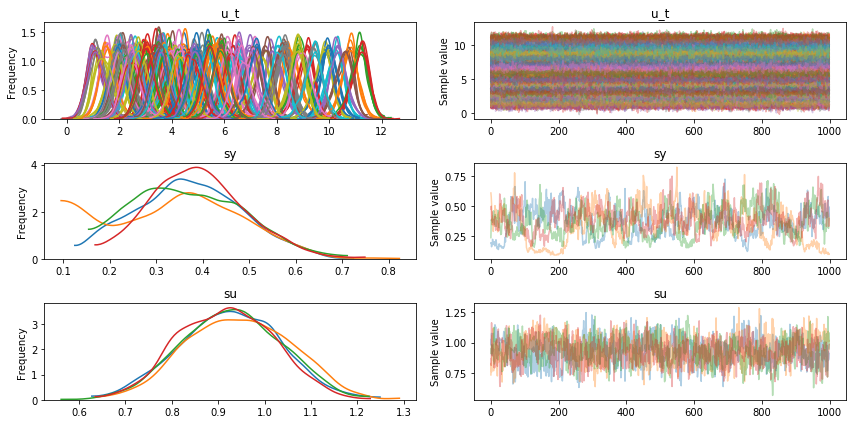

In [15]:
pm.traceplot(trace_local);

In [17]:
y_ts = pm.sample_ppc(trace_local, model=m_local)['y_t']

100%|██████████| 1000/1000 [00:00<00:00, 1709.04it/s]


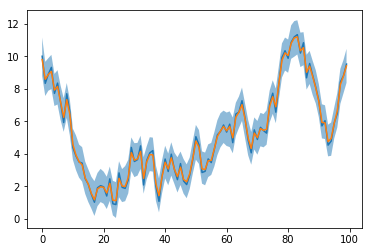

In [21]:
hpd = pm.hpd(y_ts)
pl.plot(list(range(len(data))), data)
pl.plot(list(range(len(data))), y_ts.mean(axis=0))
pl.fill_between(list(range(len(data))), hpd[:, 0], hpd[:,1], alpha=0.5);

The local linear trend model adds one line to and modifies one line from the previous model:
$$v_t \sim \mathcal{N}\left(v_{t-1}, \sigma^2_{\zeta}\right)$$
$$u_t \sim \mathcal{N}\left(u_{t-1} + v_{t-1}, \sigma^2_{\xi}\right)$$
$$y_t \sim \mathcal{N}\left(u_t, \sigma^2_\epsilon\right)$$

In [38]:
with pm.Model() as m_loc_tr:
    sy = pm.HalfCauchy('sy', 1)
    su = pm.HalfCauchy('su', 1)
    sv = pm.HalfCauchy('sv', 1)
    v_t = pm.GaussianRandomWalk('v_t', mu=0, sd=sv, shape=len(data)-1)
    u_t = pm.GaussianRandomWalk('u_t', mu=v_t, sd=su, shape=len(data))
    y_t = pm.Normal('y_t', mu=u_t, sd=sy, observed=data)
    trace_loc_tr = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u_t, v_t, sv_log__, su_log__, sy_log__]
100%|██████████| 2000/2000 [00:17<00:00, 115.78it/s]
The acceptance probability does not match the target. It is 0.440403885406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.916671375857, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.602164726991, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.934211635208, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some pa

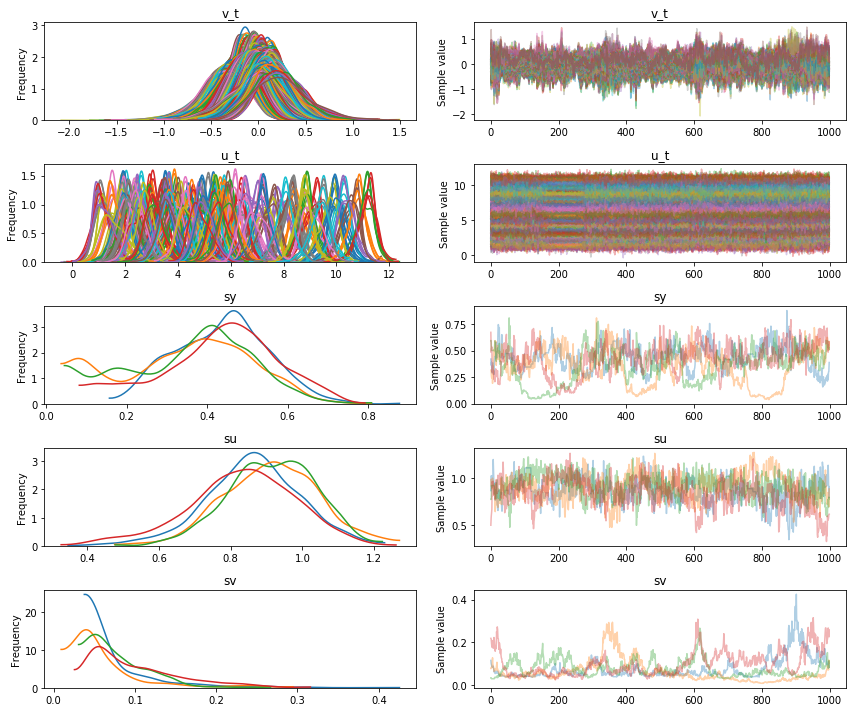

In [39]:
pm.traceplot(trace_loc_tr);

In [40]:
y_ts_2 = pm.sample_ppc(trace_loc_tr, model=m_loc_tr)['y_t']

100%|██████████| 1000/1000 [00:00<00:00, 3570.37it/s]


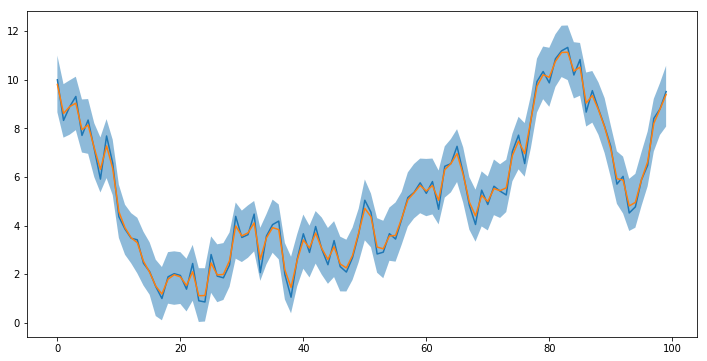

In [41]:
_, ax = pl.subplots(figsize=(12, 6))
hpd2 = pm.hpd(y_ts_2)
ax.plot(list(range(len(data))), data)
ax.plot(list(range(len(data))), y_ts_2.mean(axis=0))
ax.fill_between(list(range(len(data))), hpd2[:, 0], hpd2[:,1], alpha=0.5);